In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_pipeline.config import settings
from data_pipeline.etl.sources.geo_utils import (
    add_tracts_for_geometries,
    get_tract_geojson,
)

In [2]:
%load_ext lab_black

In [3]:
df = get_tract_geojson()

2022-08-17 11:45:46,587 [data_pipeline.etl.sources.geo_utils] INFO     Loading tract geometry data from census ETL
2022-08-17 11:45:46,588 [data_pipeline.etl.sources.geo_utils] DEBUG    Loading existing tract geojson


In [4]:
center = "6030.04"
center_GEOID10_TRACT = "24027603004"

In [5]:
df_subset = df.query(
    'STATEFP10=="24" and COUNTYFP10=="027" and NAME10 in ["6030.03", "6051.04", "6055.02", "6055.03", "6023.03", "6022.01", "6030.01", "6022.01", "6021", "6030.04"]'
)
df_subset

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10_TRACT,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
53415,24,027,602100,24027602100,6021,Census Tract 6021,G5020,S,13769934,3674,+39.3076905,-076.8349752,"POLYGON ((-76.86305 39.31484, -76.86308 39.315..."
53416,24,027,602303,24027602303,6023.03,Census Tract 6023.03,G5020,S,11740756,26901,+39.2600506,-076.8754102,"POLYGON ((-76.86750 39.25170, -76.86754 39.251..."
53424,24,027,605503,24027605503,6055.03,Census Tract 6055.03,G5020,S,3158645,8444,+39.2274469,-076.8803625,"POLYGON ((-76.88405 39.23543, -76.88398 39.235..."
53429,24,027,605502,24027605502,6055.02,Census Tract 6055.02,G5020,S,5260984,16405,+39.2257617,-076.9054701,"POLYGON ((-76.90881 39.21739, -76.90882 39.217..."
53452,24,027,603004,24027603004,6030.04,Census Tract 6030.04,G5020,S,44425097,99882,+39.2817022,-076.9188315,"POLYGON ((-76.98539 39.26610, -76.98557 39.266..."
53453,24,027,605104,24027605104,6051.04,Census Tract 6051.04,G5020,S,39969526,1553493,+39.2369323,-076.9735549,"POLYGON ((-76.97979 39.23322, -76.98018 39.233..."
53454,24,027,603003,24027603003,6030.03,Census Tract 6030.03,G5020,S,45161338,174904,+39.3192333,-076.9680454,"POLYGON ((-76.93350 39.35760, -76.93341 39.357..."
53455,24,027,603001,24027603001,6030.01,Census Tract 6030.01,G5020,S,24726303,57708,+39.3279761,-076.8942412,"POLYGON ((-76.86308 39.31501, -76.86305 39.314..."
53464,24,027,602201,24027602201,6022.01,Census Tract 6022.01,G5020,S,4611549,6125,+39.2900228,-076.8721238,"POLYGON ((-76.87750 39.30290, -76.87747 39.302..."


<AxesSubplot:>

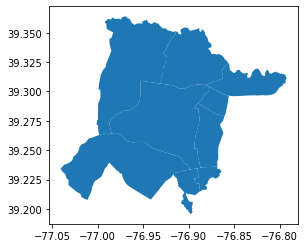

In [6]:
df_subset.plot()

In [7]:
tract_subset = df_subset.copy()

In [8]:
df_subset = df_subset[["GEOID10_TRACT", "geometry"]].copy()

In [9]:
np.random.choice([True, False], len(df_subset))

array([False, False,  True,  True, False, False, False,  True,  True])

In [10]:
df_subset_scores = df_subset.copy()
# df_subset_scores["included"] = np.random.choice([True, False], len(df_subset))
df_subset_scores["included"] = True
df_subset_scores.loc[df.GEOID10_TRACT == "24027603004", "included"] = False

In [11]:
tract_data = df_subset.rename(columns={"GEOID10_TRACT": "ORIGINAL_TRACT"})

In [12]:
df = df_subset_scores

In [13]:
df

,GEOID10_TRACT,geometry,included
53415,24027602100,"POLYGON ((-76.86305 39.31484, -76.86308 39.315...",True
53416,24027602303,"POLYGON ((-76.86750 39.25170, -76.86754 39.251...",True
53424,24027605503,"POLYGON ((-76.88405 39.23543, -76.88398 39.235...",True
53429,24027605502,"POLYGON ((-76.90881 39.21739, -76.90882 39.217...",True
53452,24027603004,"POLYGON ((-76.98539 39.26610, -76.98557 39.266...",False
53453,24027605104,"POLYGON ((-76.97979 39.23322, -76.98018 39.233...",True
53454,24027603003,"POLYGON ((-76.93350 39.35760, -76.93341 39.357...",True
53455,24027603001,"POLYGON ((-76.86308 39.31501, -76.86305 39.314...",True
53464,24027602201,"POLYGON ((-76.87750 39.30290, -76.87747 39.302...",True


In [14]:
adjacent_tracts: gpd.GeoDataFrame = df.sjoin(
    tract_data, how="left", predicate="touches"
)

In [15]:
adjacent_tracts.groupby("ORIGINAL_TRACT")[
    ["included"]
].mean().reset_index().rename(columns={"ORIGINAL_TRACT": "GEOID10_TRACT"})

,GEOID10_TRACT,included
0,24027602100,0.666667
1,24027602201,0.666667
2,24027602303,0.666667
3,24027603001,0.666667
4,24027603003,0.666667
5,24027603004,1.000000
6,24027605104,0.666667
7,24027605502,0.666667
8,24027605503,0.666667


# Make test data

In [18]:
tract_subset.to_file("../tests/score/test_utils/data/us.geojson", index=False)

In [21]:
df[["GEOID10_TRACT", "included"]].to_csv(
    "../tests/score/test_utils/data/scores.csv", index=False
)